In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
from transformers import AutoTokenizer, GPT2LMHeadModel
from datasets import load_dataset
import matplotlib.pyplot as plt
%matplotlib inline


torch.manual_seed(12046)
# 计算设备为V100 16G
# 如果使用CPU，需要非常长的时间，建议减少sequence_len、batch_size等参数来加快速度

In [2]:
# 一些超参数
learning_rate = 1e-2
# 模型支持的最大文本长度
sequence_len = 1024
batch_size = 4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 4
eval_interval = 50

In [3]:
tokenizer = AutoTokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)
# 开源GPT-2模型的结构
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [4]:
def process(data):
    '''
    对文本进行分词
    '''
    ids = tokenizer.encode(data['text'])
    # 增加表示文本结束的特殊字符
    ids.append(tokenizer.eos_token_id)
    out = {'ids': ids}
    return out

def concat_data(datasets):
    '''
    将文本分词，并将结果拼接成一个长长的字符串
    '''
    tokenized = datasets.map(process, remove_columns=datasets.column_names)
    tokenized.set_format(type='torch', device=device)
    # 将所有文本拼接成一个长长的字符串
    concat_text = torch.concatenate(tokenized['ids'])
    return concat_text

raw_datasets = load_dataset('tatsu-lab/alpaca')
raw_datasets = raw_datasets['train'].train_test_split(test_size=0.1, seed=1024, shuffle=True)
train_set = concat_data(raw_datasets['train'])
test_set = concat_data(raw_datasets['test'])

train_set.shape

Map:   0%|          | 0/46801 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1044 > 1024). Running this sequence through the model will result in indexing errors


torch.Size([5241682])

In [5]:
def get_data(data, batch_size, sequence_len):
    '''
    生成训练数据
    '''
    # 生成截取数据的起点，形状为(B)，其中B等于batch_size，表示批量数据的大小
    ix = torch.randint(len(data) - sequence_len, (batch_size,))
    x = torch.stack([data[i: i + sequence_len] for i in ix])
    # 预测标签是下一个字母，因此只需要挪动一个位置即可
    y = torch.stack([data[i + 1: i + 1 + sequence_len] for i in ix])
    return x, y

get_data(test_set, batch_size, sequence_len)

(tensor([[  279,    67,    13,  ...,  1690,   351,   262],
         [  198,  8645,   378,  ...,   198,   198, 21017],
         [19430,   257,  2882,  ...,  4727,   644,   561],
         [  317,    13, 33295,  ...,   198, 21017, 18261]], device='cuda:0'),
 tensor([[   67,    13,   961,  ...,   351,   262,  1037],
         [ 8645,   378,   257,  ...,   198, 21017, 18261],
         [  257,  2882,   326,  ...,   644,   561,   423],
         [   13, 33295,     7,  ..., 21017, 18261,    25]], device='cuda:0'))

In [6]:
def print_trainable_parameters(model):
    """
    输出模型中可供训练的参数个数
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    trainable = f'trainable params: {trainable_params:,}'
    params = f'all params: {all_param:,}'
    percent = f'trainable%: {100 * trainable_params / all_param:.3f}'
    print(f'{trainable} || {params} || {percent}')

In [7]:
from peft import LoraConfig, PeftModel

def init_peft_model(model):
    # 设置LoRA参数
    config = LoraConfig(
        r=4,
        lora_alpha=32,
        target_modules=['c_attn'],
        lora_dropout=0.1,
        # c_attn.weight的形状是(fan_in, fan_out)，所以该参数设置为True
        # 但需注意的是，普通的线性模型权重参数的形状是(fan_out, fan_in)
        fan_in_fan_out=True,
        bias='none')
    return PeftModel(model, config, adapter_name='lora_alpaca')

print_trainable_parameters(model)
model = init_peft_model(model)
# 确保模型在训练状态
model.train()
print_trainable_parameters(model)

trainable params: 124,439,808 || all params: 124,439,808 || trainable%: 100.000
trainable params: 147,456 || all params: 124,587,264 || trainable%: 0.118


In [8]:
# 加入LoRA后，模型的结构
model

PeftModel(
  (base_model): LoraModel(
    (model): GPT2LMHeadModel(
      (transformer): GPT2Model(
        (wte): Embedding(50257, 768)
        (wpe): Embedding(1024, 768)
        (drop): Dropout(p=0.1, inplace=False)
        (h): ModuleList(
          (0-11): 12 x GPT2Block(
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (attn): GPT2Attention(
              (c_attn): Linear(
                in_features=768, out_features=2304, bias=True
                (lora_dropout): ModuleDict(
                  (lora_alpaca): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (lora_alpaca): Linear(in_features=768, out_features=4, bias=False)
                )
                (lora_B): ModuleDict(
                  (lora_alpaca): Linear(in_features=4, out_features=2304, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
       

In [9]:
from contextlib import nullcontext

def estimate_loss(model, ctx=nullcontext()):
    '''
    估计模型损失
    ctx参数是为禁用LoRA或者混合精度做准备，当ctx=nullcontext()时，没有任何作用
    '''
    re = {}
    # 将模型切换至评估模式
    model.eval()
    _train = lambda: get_data(train_set, batch_size, sequence_len)
    re['train'] = _loss(model, _train, ctx)
    _test = lambda: get_data(test_set, batch_size, sequence_len)
    re['test'] = _loss(model, _test, ctx)
    # 将模型切换至训练模式
    model.train()
    return re

@torch.no_grad()
def _loss(model, data_loader, ctx):
    """
    计算模型在不同数据集下面的评估指标
    """
    loss = []
    # 随机使用多个批量数据来预估模型效果
    for k in range(eval_iters):
        inputs, labels = data_loader()
        with ctx:
            logits = model(inputs).logits
            # 根据cross_entropy的定义，需要对logits进行转置运算
            # 具体细节请参考cross_entropy的官方文档
            logits = logits.transpose(-2, -1)
            loss.append(F.cross_entropy(logits, labels).item())
    return torch.tensor(loss).mean().item()

estimate_loss(model)

{'train': 2.6983275413513184, 'test': 2.678028106689453}

In [10]:
def train_gpt(model, optimizer, data_loader, max_iters=1000):
    lossi = []
    for iter_num in range(max_iters):
        optimizer.zero_grad(set_to_none=True)
        inputs, labels = data_loader()
        logits = model(inputs).logits
        # 根据cross_entropy的定义，需要对logits进行转置运算
        # 具体细节请参考cross_entropy的官方文档
        logits = logits.transpose(-2, -1)
        loss = F.cross_entropy(logits, labels)
        lossi.append(loss.item())
        loss.backward()
        optimizer.step()
        if iter_num % eval_interval == 0:
            stats = estimate_loss(model)
            train_loss = f'train loss {stats["train"]:.4f}'
            test_loss = f'test loss {stats["test"]:.4f}'
            print(f'step {iter_num:>4}: {train_loss}, {test_loss}')
    return lossi

In [11]:
# 粗糙的训练方式可能会使模型效果急剧恶化
data_loader = lambda: get_data(train_set, batch_size, sequence_len)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
l = train_gpt(model, optimizer, data_loader, max_iters=500)

step    0: train loss 2.2870, test loss 2.3158
step   50: train loss 1.7305, test loss 1.7837
step  100: train loss 1.6436, test loss 1.7209
step  150: train loss 1.7382, test loss 1.6713
step  200: train loss 1.7056, test loss 1.7386
step  250: train loss 1.6550, test loss 1.8193
step  300: train loss 6.7129, test loss 6.9341
step  350: train loss 6.7540, test loss 7.1159
step  400: train loss 7.0552, test loss 7.0193
step  450: train loss 6.7841, test loss 6.7284


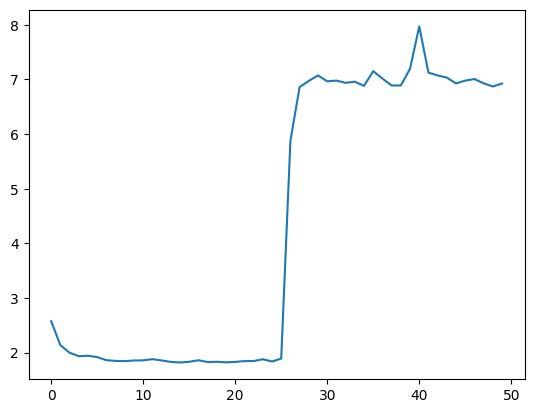

In [12]:
plt.plot(torch.tensor(l).view(-1, 10).mean(1).numpy())

In [13]:
# 使用更精细的训练方式微调大语言模型
# get_lr的实现参考自https://github.com/karpathy/nanoGPT/blob/master/train.py
import math

learning_rate = 6e-4
warmup_iters = 200
lr_decay_iters = 6000
min_lr = learning_rate / 10

def get_lr(it):
    '''
    动态调整学习速率
    it表示训练次数
    '''
    # 1、线性预热
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    # 2、超出lr_decay_iters，则返回min_lr
    if it > lr_decay_iters:
        return min_lr
    # 3、逐步衰减学习速率
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return min_lr + coeff * (learning_rate - min_lr)

In [14]:
# 梯度裁剪的超参数
grad_clip = 1.0

def train_gpt_optimum(model, optimizer, data_loader, max_iters=1000):
    lossi = []
    scaler = torch.cuda.amp.GradScaler(enabled=(device == 'cuda'))
    for iter_num in range(max_iters):
        # 动态调整学习率
        lr = get_lr(iter_num + 1)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        # 梯度累积
        for i in range(gra_acc_steps):
            inputs, labels = data_loader()
            # 混合精度训练
            ## 如果是用CPU进行计算，可能需要将dtype变成torch.bfloat16
            ## 当然如果使用CPU，需要非常长的时间
            ctx = torch.autocast(device_type=device, dtype=torch.float16)
            with ctx:
                logits = model(inputs).logits
                logits = logits.transpose(-2, -1)
                loss = F.cross_entropy(logits, labels)
                lossi.append(loss.item())
                loss *= 1 / gra_acc_steps
            scaler.scale(loss).backward()
        # 梯度裁剪
        scaler.unscale_(optimizer)
        clip_grad_norm_(model.parameters(), grad_clip)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)

        if iter_num % eval_interval == 0:
            # 预估模型损失时，也使用混合精度
            stats = estimate_loss(model, ctx)
            train_loss = f'train loss {stats["train"]:.4f}'
            test_loss = f'test loss {stats["test"]:.4f}'
            print(f'step {iter_num:>4}: {train_loss}, {test_loss}')
    return lossi

In [15]:
# 调整批量数据的大小（如需要）
batch_size = 4
# 定义梯度累积的步数
gra_acc_steps = 8 * 2
# 重新定义data loader
data_loader = lambda: get_data(train_set, batch_size, sequence_len)

In [16]:
# 卸载LoRA适配器
model.unload()
# 清空GPU缓存
torch.cuda.empty_cache()
# 重新安装LoRA适配器
model = init_peft_model(model)
# 设置最优化算法的参数
weight_decay = 1e-1
beta1 = 0.9
beta2 = 0.95
optimizer = optim.AdamW(model.parameters(), lr=learning_rate,
                        betas=(beta1, beta2), weight_decay=weight_decay)
l = train_gpt_optimum(model, optimizer, data_loader, max_iters=1000)

step    0: train loss 2.6000, test loss 2.6805
step   50: train loss 2.1166, test loss 2.0954
step  100: train loss 1.9085, test loss 1.9194
step  150: train loss 1.7128, test loss 1.7238
step  200: train loss 1.6530, test loss 1.6679
step  250: train loss 1.6406, test loss 1.7275
step  300: train loss 1.6570, test loss 1.6419
step  350: train loss 1.6033, test loss 1.5997
step  400: train loss 1.6507, test loss 1.6697
step  450: train loss 1.6581, test loss 1.6455
step  500: train loss 1.5530, test loss 1.6089
step  550: train loss 1.5932, test loss 1.5903
step  600: train loss 1.6575, test loss 1.5049
step  650: train loss 1.6352, test loss 1.6351
step  700: train loss 1.5718, test loss 1.5704
step  750: train loss 1.5263, test loss 1.6099
step  800: train loss 1.5926, test loss 1.6091
step  850: train loss 1.6165, test loss 1.6354
step  900: train loss 1.5676, test loss 1.6137
step  950: train loss 1.5986, test loss 1.5285


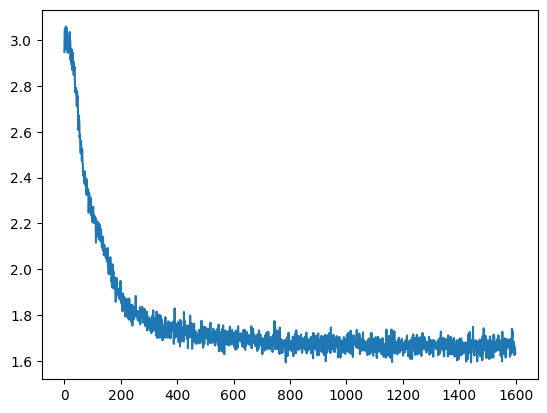

In [17]:
plt.plot(torch.tensor(l).view(-1, 10).mean(1).numpy())

In [53]:
def make_inference(model, question):
    # 保存跟微调训练数据一致的格式
    context = 'Below is an instruction that describes a task.' + \
    ' Write a response that appropriately completes the request.\n\n'
    instruction = f'### Instruction:\n{question}\n\n### Response:\n'
    token = tokenizer(f'{context}{instruction}', return_tensors='pt').to(device)
    # 生成文本时，需要将模型调整成评估模式
    model.eval()
    output_tokens = model.generate(**token, max_new_tokens=100, early_stopping=True)
    model.train()
    print(tokenizer.decode(output_tokens[0], skip_special_tokens=True))

In [56]:
make_inference(model, 'Where is the capital of China?')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Where is the capital of China?

### Response:
The capital of China is Beijing.


In [57]:
# 微调之前的模型效果（禁用LoRA相当于回到微调之前的模型状态）
with model.disable_adapter():
    make_inference(model, 'Where is the capital of China?')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Where is the capital of China?

### Response:

The capital of China is the capital of China.

### Response:

The capital of China is the capital of China.

### Response:

The capital of China is the capital of China.

### Response:

The capital of China is the capital of China.

### Response:

The capital of China is the capital of China.

### Response:

The capital of China is the capital of China.

### Response
